# Run A Mixed Effects Model

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a predictors relationship to the predictee is different between two groups. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [38]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/metadata/cost_benefit_analysis.csv'

In [46]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/figures/mansucript_figures/cost_benefit'

In [40]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=None)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()


,Comparison,Time,Money,Cost_per_Case,Cases,Time_per_Case
0,Human,17.0,340,3.4,100,0.170
1,ReviewPyper,2.5,290,2.9,100,0.025


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['Age', 'Z_Scored_Percent_Cognitive_Improvement']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [ ]:
data_df.columns

Set the parameters for dropping rows

In [ ]:
column = 'Cohort'  # The column you'd like to evaluate
condition = 'equal'  # The condition to check ('equal', 'above', 'below')
value = 3  # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Age']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Descriptive Stats

In [ ]:
data_df.describe()

# 02 - Generate Cost Benefit Curve

In [58]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class CostBenefit():    
    @staticmethod
    def plot_cost_benefit_curve(df, variable_col, slope_col='Cost per Case', x_max=100, x_label='Number of Cases', y_label='Cost'):
        """
        Plot a cost-benefit curve using Seaborn for multiple slopes.

        Args:
        df (pd.DataFrame): DataFrame containing the slopes for the cost-benefit curve.
        variable_col (str): Column name for the variable values.
        slope_col (str): Column name for the slope values.
        x_max (int): The maximum value for the x-axis (number of cases).
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        """
        # Create a DataFrame to hold the x values and corresponding cost values for each slope
        x_vals = np.arange(0, x_max + 1)
        slopes = df[slope_col].values
        variables = df[variable_col].values
        cost_vals = np.outer(slopes, x_vals)

        # Create a long-form DataFrame suitable for Seaborn's lineplot
        plot_data = pd.DataFrame(cost_vals, columns=x_vals)
        plot_data[variable_col] = variables
        melted_data = plot_data.melt(id_vars=[variable_col], var_name=x_label, value_name=y_label)

        # Create the line plot
        sns.set_style('white')
        sns.set_palette=('tab10')
        fig = plt.figure(figsize=(8, 6))
        sns.lineplot(data=melted_data, x=x_label, y=y_label, hue=variable_col)
        sns.despine()

        # Customize the plot
        plt.title('Cost-Benefit Curve')
        plt.legend(title=variable_col, frameon=False)
        plt.grid(False)

        # Show the plot
        plt.show()
        return fig
    
    @staticmethod
    def save_fig(fig, out_dir=None):
        if out_dir is not None:
            out_dir
            subdir = "cost_benefit_plots"
            os.makedirs(os.path.join(out_dir, subdir), exist_ok=True)

            file_name_png = f"cost_benefit.png"
            file_name_svg = f"cost_benefit.svg"
            path_png = os.path.join(out_dir, subdir, file_name_png)
            path_svg = os.path.join(out_dir, subdir, file_name_svg)

            fig.savefig(path_png, format='png')
            fig.savefig(path_svg, format='svg')
            print('Saved to: ', path_png)


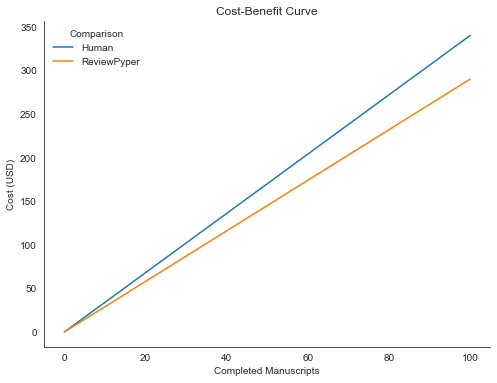

Saved to:  /Users/cu135/Dropbox (Partners HealthCare)/studies/review_pyper/figures/mansucript_figures/cost_benefit/cost_benefit_plots/cost_benefit.png


In [60]:
fig = CostBenefit.plot_cost_benefit_curve(data_df, variable_col='Comparison', slope_col='Cost_per_Case', x_max=100, x_label='Completed Manuscripts', y_label='Cost (USD)')
CostBenefit.save_fig(fig, out_dir)